# Tarefa 3 - Liver Disorder (MLP)

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt




#from sklearn.datasets import make_classification

from sklearn import model_selection
from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor

from sklearn import metrics
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import EarlyStopping

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler  

import statistics




## Importação de base

In [2]:
df = pd.read_csv('/home/alex/Documentos/liver-disorder/bupa.data',names = ['mcv','alkphos','sgpt','sgot','gammagt','drinks','selector'])

   Attribute information
   
   1. mcc: mean corpuscular volume
   2. alkphos: alkaline phosphotase
   3. sgpt: alamine aminotransferase
   4. sgot: aspartate aminotransferase
   5. gammagt: gamma-glutamyl transpeptidase
   6. drinks: number of half-pint equivalents of alcoholic beverages drunk per day
   7. selector: field used to split data into two sets


In [3]:
df.sample(10)

,mcv,alkphos,sgpt,sgot,gammagt,drinks,selector
46,92,56,14,16,10,0.5,2
206,90,73,24,23,11,0.5,1
267,89,109,26,25,27,2.0,2
317,92,80,10,26,20,6.0,1
169,97,71,29,22,52,8.0,1
282,82,68,20,22,9,4.0,2
178,92,95,85,48,200,8.0,2
269,93,58,20,23,18,2.0,2
76,87,90,43,28,156,2.0,2
167,92,93,58,35,120,7.0,1


In [4]:
len(df)

345

## Insights da base

In [5]:
df['drinks'].value_counts(dropna = False, normalize = True).sort_index().to_frame()

,drinks
0.0,0.026087
0.5,0.313043
1.0,0.049275
2.0,0.101449
3.0,0.060870
4.0,0.144928
5.0,0.049275
6.0,0.115942
7.0,0.017391
8.0,0.060870


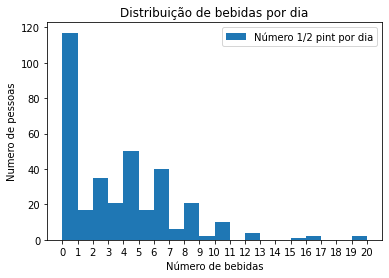

In [6]:
plt.hist(df['drinks'],label = 'Número 1/2 pint por dia',bins=20)
plt.title('Distribuição de bebidas por dia')
plt.xlabel('Número de bebidas')
plt.ylabel('Numero de pessoas')
plt.legend(loc='upper right')
plt.xticks(range(0, 21))
plt.show()

### Alguns papers indicam que as doenças hepáticas estão associadas a um consumo acima de 5 drinks por dia
 - Essa informação também é mencionada na descrição do dataset
 - Assim, classificamos como 1 aqueles que bebem mais de 5 e como 0 os que bebem até 5
 - Também ignoramos a coluna selector pois indicava apenas uma possível divisão dos dados
 - Depois de classificar, passamos a ignorar a característica 'drinks' dada que a correlação dela, por construção, é muito forte com a variável objetivo

In [7]:
df['class'] = np.select([df['drinks']>5],
                       [1],0)

In [8]:
df['class'].value_counts(dropna = False)

0    257
1     88
Name: class, dtype: int64

In [9]:
df_res = df.drop(columns=['drinks','selector'])

In [10]:
df_res.head()

,mcv,alkphos,sgpt,sgot,gammagt,class
0,85,92,45,27,31,0
1,85,64,59,32,23,0
2,86,54,33,16,54,0
3,91,78,34,24,36,0
4,87,70,12,28,10,0


## Desenvolvimento

### Matriz de Confusão

In [11]:
def accuracy(confusion_matrix):
   diagonal_sum = confusion_matrix.trace()
   sum_of_all_elements = confusion_matrix.sum()
   return diagonal_sum / sum_of_all_elements

### Treino, teste e normalização

#### Parâmetros
 - with_mean -> Aqui foi utilizado o valor 6 que é correspondente ao número de features do df
 - with_std -> Dimensiona os dados para a variação da unidade (ou, de forma equivalente, o desvio padrão da unidade). 

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df_res.drop('class',axis=1),df_res['class'],test_size=0.3, random_state = 42)
#Opções:
# Normalizer
# KBinsDiscretizer
# StandardScaler
scaler = preprocessing.StandardScaler(with_mean = 5, with_std = True)
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
print(X_train)

[[ 0.17876537 -0.6360714  -0.02269914 -0.17800473  0.09426163]
 [ 0.17876537  0.69540283 -0.48240438 -0.57247958 -0.64968861]
 [ 0.17876537 -0.80974195 -0.29852229 -0.27662344 -0.09172593]
 ...
 [ 0.17876537  0.69540283  0.25312401 -0.17800473 -0.30428315]
 [-0.45170957 -0.6360714  -1.03405068 -0.96695442 -0.59654931]
 [-0.24155125 -0.2887303  -0.43643386  0.21647012 -0.75596722]]


### MLP

#### Parâmetros
 - hidden_layer_sizes -> Número de camdas de entrada, número de camadas escondidas, número de camadas de saída
 - Função de ativação -> tangente hiperbólica
 - alpha -> termo de regularização ou parâmetro de penalidade
 - solver -> otimizador de pesos
 - max_iter -> máximo de iterações permitido
 - batch_size -> o tamanho dos minibatches para para otimizadores estocásticos
 - learning_rate_init -> Determinar o tamaho do passo na atualização dos pesos

### Relatório

#### Descrição do relatório de classificação
 - As médias relatadas incluem macro avg (média da média não ponderada por rótulo), weighted avg (média da média ponderada de suporte por rótulo) e sample average(apenas para classificação multilabel). 
 - Precision = True Positive / Total Predicted Positive
 - Recall = True Positive / Total Actual Positive
 - F1 = 2*((Precision*Recall)/(Precision+Recall))

### Modelo

In [50]:
model = MLPClassifier(hidden_layer_sizes=(50,10,20),
                      #verbose = 10,
                      activation="tanh",#'tanh','relu'
                      alpha = 1e-06,
                      solver='adam',#'lbfgs'
                      #random_state=10,
                      max_iter=500,
                      early_stopping = False,
                      learning_rate = 'constant',#'constant','invscaling'
                      warm_start = False,
                      batch_size = 50,
                      learning_rate_init = 0.0001,
                     )

### Repetições

In [51]:
acuracia_media = []

i = 1
while i <= 5:
    
    print('Repetição: ',i)
    
    model = model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    print('\nMLP',metrics.classification_report(y_test,y_pred))

    cm = confusion_matrix(y_pred, y_test)
    acuracia_media.append(accuracy(cm))
    print('Accuracy: ',"%.2f" %accuracy(cm),'\n\n')

    i = i+1
    
desvio_padrao = statistics.stdev(acuracia_media)
media = statistics.mean(acuracia_media)
print('\nAcuracia Média: ',"%.2f" %media,'\nDesvio Padrão: ',"%.5f" %desvio_padrao)

Repetição:  1

MLP               precision    recall  f1-score   support

           0       0.80      0.96      0.87        76
           1       0.77      0.36      0.49        28

    accuracy                           0.80       104
   macro avg       0.79      0.66      0.68       104
weighted avg       0.79      0.80      0.77       104

Accuracy:  0.80 


Repetição:  2

MLP               precision    recall  f1-score   support

           0       0.80      0.97      0.88        76
           1       0.83      0.36      0.50        28

    accuracy                           0.81       104
   macro avg       0.82      0.67      0.69       104
weighted avg       0.81      0.81      0.78       104

Accuracy:  0.81 


Repetição:  3

MLP               precision    recall  f1-score   support

           0       0.80      0.97      0.88        76
           1       0.83      0.36      0.50        28

    accuracy                           0.81       104
   macro avg       0.82      0.67